Sezione dedicata alla community detection tra gl iagent del nostro social

In [3]:
# Setting ambiente
import json
import os
import networkx as nx
import networkx.algorithms.community as nx_comm
import community
from infomap import Infomap
from collections import defaultdict

file_path = '/data/homes_data/mattiatrapletti/SimPy/social/data/simulations.json'

In [4]:
# Creazione archi
def estrai_archi_da_json(file_path,G):
    with open(file_path, 'r') as f:
        data = json.load(f)
    archi = set()  # Usare un set per evitare duplicati

    # Itera attraverso gli agenti nel file JSON
    for agente in data['simulations'][0]['agents']:
        agent_id = int(agente['agent_id'])  # ID dell'agente corrente
        friends_list = agente['friends_list']  # Lista degli amici dell'agente

        for friend in friends_list:
            G.add_edge(agent_id, friend)
        
    return list(archi) 

In [5]:
# Creazione grafo
G = nx.Graph()
if os.path.exists(file_path):
    lista_archi = estrai_archi_da_json(file_path,G)
else:
    print("Il file al momento non esiste")


In [ ]:
# Info sul grafo
print(f"Numero di nodi: {G.order()}")
print(f"Numero di archi: {G.size()}")

degrees = [degree for node, degree in G.degree()]
max_degree = max(degrees)
print(f'Max Degree: {max(degrees)}')
print(f'Min Degree: {min(degrees)}')
print(f'Density: {nx.density(G)}')
print(f'Average Degree: {sum(degrees) / len(degrees)}')

Numero di nodi: 10
Numero di archi: 29
Max Degree: 8
Min Degree: 5
Density: 0.6444444444444445
Average Degree: 5.8


Community detection

In [6]:
im = Infomap()
pairs = [e for e in G.edges()]
im.add_links( pairs )

In [7]:
def findCommunities_infomap(im):

    print("Find communities with Infomap...")
    im.run()
    print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")
    communities = {}
    for node in im.tree:
        if node.is_leaf:
            #print(node.node_id, node.module_id)
            communities[node.node_id] = node.module_id
    
    return communities

In [8]:
partition_infomap = findCommunities_infomap(im = im)

Find communities with Infomap...
  Infomap v2.8.0 starts at 2024-08-22 10:14:45
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 24 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 10 nodes and 29 links...
  -> One-level codelength: 3.30230838

Trial 1/1 starting at 2024-08-22 10:14:45
Two-level compression: -9.4e-14% 
Partitioned to codelength 0 + 3.30230838 = 3.302308377 in 1 (0 non-trivial) modules.

=> Trial 1/1 finished in 0.00015559s with codelength 3.30230838


Summary after 1 trial
Best end modular solution in 2 levels (warning: worse than one-level solution):
PerFound 1 modules with codelength: 3.3023083772039876
 level number of modules:         [          1,           0] (sum: 1)
Per level number of leaf nodes:      [          0,          10] (sum: 

In [9]:
from matplotlib import pyplot as plt


def draw_network_colored(g, p, color_for_nodes, nodesize = 600):
    plt.figure(figsize = (15,7))
    nx.draw_networkx(g,
                     pos=p,
                     font_size = 12, 
                     font_weight = 'bold',
                     font_color = 'navy',
                     edge_color = 'grey'
                    )
    
    nodes = nx.draw_networkx_nodes(g, p, node_color=[color_for_nodes[n] for n in g.nodes()],
                     node_size = nodesize)
                     
    nodes.set_edgecolor('lightgrey')
    plt.axis('off')
    plt.show()


p = nx.spring_layout(G)

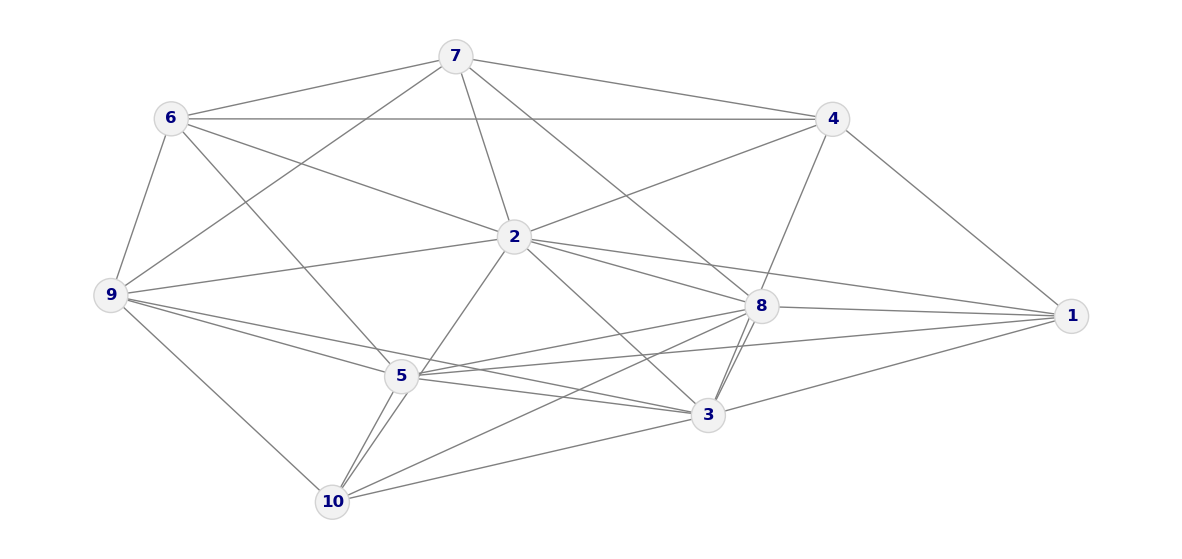

In [10]:
# Disegno del grafo
from mycolorpy import colorlist as mcp
get_color_list = lambda ncolors, cmap : mcp.gen_color(cmap=cmap,n=ncolors)
comm_index = set(partition_infomap.values())
colors = {}
for comm,c in zip(comm_index,get_color_list(len(comm_index), 'Pastel1_r' )):
    colors[comm] = c
    
colors_for_node_infomap = {}
for node,c in partition_infomap.items():
    colors_for_node_infomap[node] = colors[c]

draw_network_colored(G, p, colors_for_node_infomap)

In [ ]:
# Coverage
intra_edges = 10 # 5 in ogni community
all_edges = G.size()
print(f'Coverage: {intra_edges/all_edges}')

Quality: 0.3448275862068966


In [ ]:
# Performance
potential = (8*7)/2 # (n*n-1)/2
inter_no = (4*4) -1 # 4=nodes in each community. 
# tutti gli inter-community edge possibili sono 4*4 (bipartito)
# -1 perchè è il numero di inter-community edge che esiste
print(f'Quality: {(inter_no+intra_edges)/potential}')

Quality: 0.8928571428571429


In [ ]:
# Classifica community
community_sizes = defaultdict(int)
for node, community in partition_infomap.items():
    community_sizes[community] += 1

# Converti il risultato in una lista di tuple e ordina in base alla dimensione
sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)

# Stampa le comunità più grandi
print("Le comunità più grandi sono:")
for community, size in sorted_communities[:10]:  # Modifica il numero 10 per mostrare più o meno comunità
    print(f"Community {community}: {size} nodes")

Le comunità più grandi sono:
Community 1: 10 nodes


In [11]:
# Salvataggio della rete su file
communities = {node.physicalId: node.module_id for node in im.tree if node.is_leaf}
nx.set_node_attributes(G, communities, 'infomap-comm')
nx.write_gexf(G, "G_withcomm.gexf")